In [153]:
import sys
sys.path.insert(0, r'D:\MicrosoftEdgeDownloads\lsanomaly_v1.2')
import lsanomaly
import numpy as np
import scipy.signal
import pylab as plt
import pandas as pd
import seaborn as sb
%matplotlib inline

In [154]:
# Use electrocardiogram data from PhysioNet as an example.
# More data can be downloaded from http://www.physionet.org/cgi-bin/ATM
# Select MIT-BIH Arrhythmia Database (mitdb), and export as CSV.
X = np.loadtxt(r'D:\MicrosoftEdgeDownloads\lsanomaly_v1.2\data//MIT_physionet_sample.csv',skiprows=2, 
               usecols=(1,2), delimiter=',')
X[:,0] = X[:,0] - scipy.signal.medfilt(X[:,0],kernel_size=301)
#X[:,1] = X[:,1] - scipy.signal.medfilt(X[:,1],kernel_size=301)

# Construct 4-D  observations from the original 2-D data: values at the
# current index and at a fixed lag behind.
N = X.shape[0]
lag = 10
X2 = np.zeros((N-lag,2))
for i in range(lag,N):
    X2[i-lag,0] = X[i,0]
    X2[i-lag,1] = X[i-lag,0]
#    X2[i-lag,2] = X[i,1]
#    X2[i-lag,3] = X[i-lag,1]   

In [155]:
raw = pd.read_csv(r'C:\Users\lenovo\Downloads\chart (3).csv')
Y = raw['NDVI']#+Y['NDVI reconstructed']
Y = Y.append(raw['NDVI reconstructed'])
Y = Y.as_matrix()

In [156]:
Y = Y - scipy.signal.medfilt(Y, kernel_size=3)
N = Y.shape[0]
lag = 10
Y2 = np.zeros((N-lag,2))
for i in range(lag,N):
    Y2[i-lag,0] = Y[i]
    Y2[i-lag,1] = Y[i-lag]

In [157]:
raw.shape

(319, 3)

In [158]:
Y_train = Y2[319::,:]
Y_test = Y2[0:319,:]

In [159]:
X_train = X2[:5000,:]
X_test = X2[10000:15000,:]

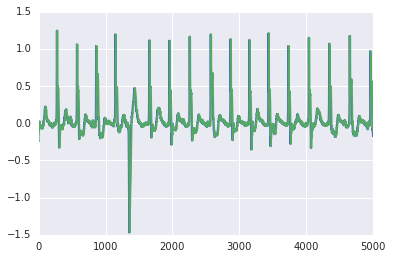

In [160]:
plt.plot(X_test[:,0])
plt.plot(X_test[:,1])

In [161]:
# Train the model
anomalymodel = lsanomaly.LSAnomaly(rho=1, sigma=.5)
anomalymodel.fit(Y_train)

# Predict anomalies statically (assuming iid samples)
y_pred_static = anomalymodel.predict_proba(Y_test)

# Predict anomalies sequentially (assume known transition matrix and
# initial probabilities)
A = np.array([[.999, .001],[.01, .99]])
pi = np.array([.5,.5])
y_pred_dynamic = anomalymodel.predict_sequence(Y_test, A, pi)

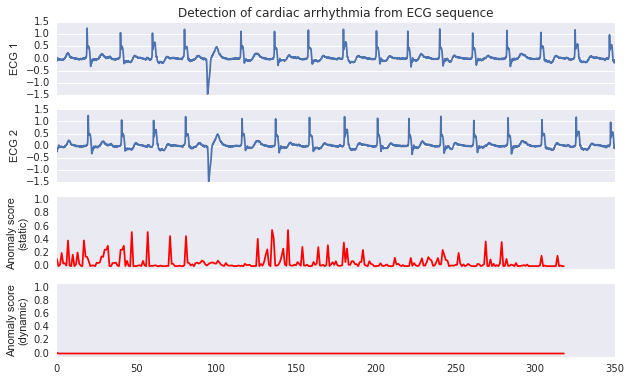

In [162]:
plt.clf()
plt.figure(figsize=(10,6))
plt.subplot(4,1,1)
plt.plot(X_test[:,0])
plt.ylabel('ECG 1')#,rotation='horizontal')
plt.grid(which='major',axis='x')
plt.xticks(plt.xticks()[0],'')
plt.title('Detection of cardiac arrhythmia from ECG sequence')
plt.subplot(4,1,2)
plt.plot(X_test[:,1])     
plt.grid(which='major',axis='x')
plt.xticks(plt.xticks()[0],'')
plt.ylabel('ECG 2')#,rotation='horizontal')
plt.subplot(4,1,3)
plt.plot(y_pred_static[:,1],'r')
plt.xticks(plt.xticks()[0],'')
plt.grid(which='major',axis='both')
plt.ylim([-.05,1.05])
plt.ylabel('Anomaly score\n(static)')#,rotation='horizontal')
plt.subplot(4,1,4)
plt.plot(y_pred_dynamic[:,1],'r')  
plt.grid(which='major',axis='both')
plt.ylim([-.05,1.05])
plt.ylabel('Anomaly score\n(dynamic)')#,rotation='horizontal')
plt.show()

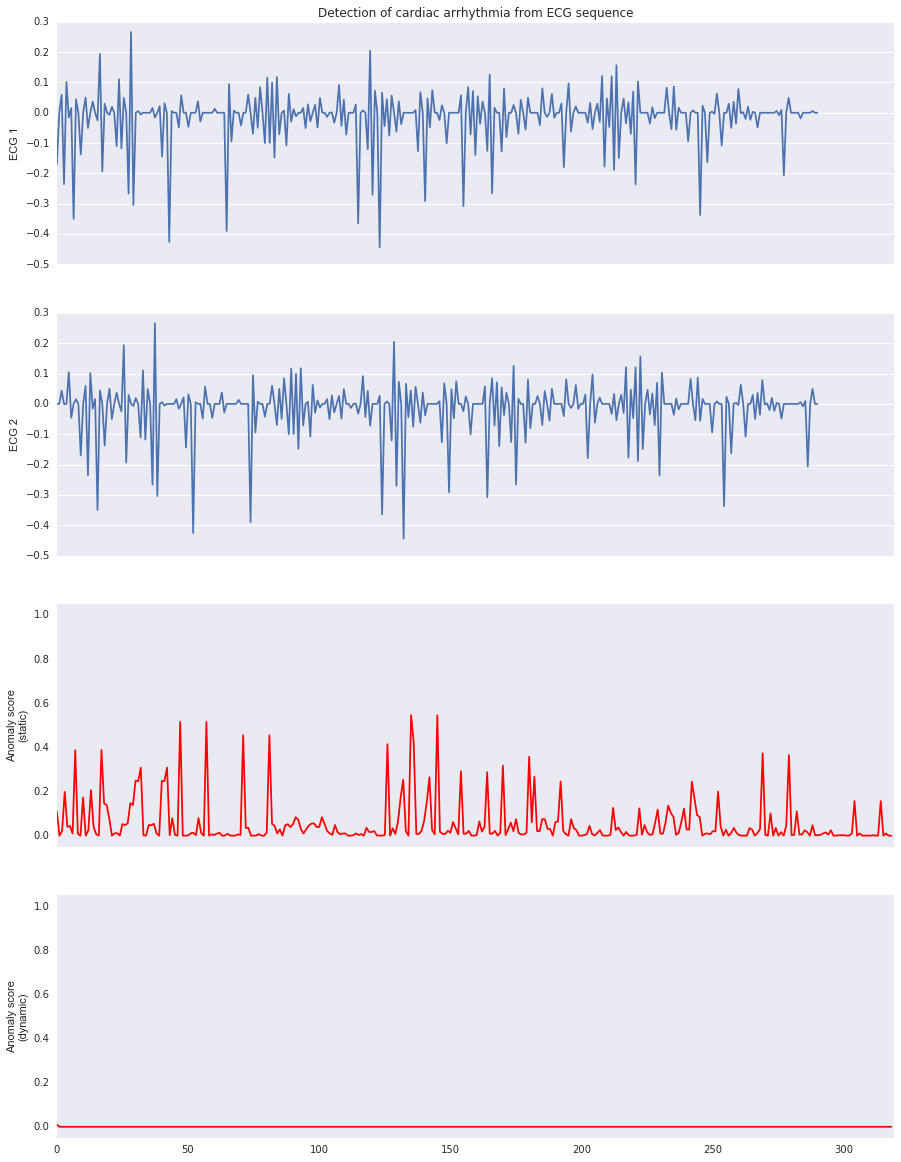

In [163]:
plt.clf()
plt.figure(figsize=(15,20))
#plt.figure(figsize=(10,6))
plt.subplot(4,1,1)
plt.plot(Y_test[:,0])
plt.xlim([0,319])
plt.ylabel('ECG 1')#,rotation='horizontal')
plt.grid(which='major',axis='x')
plt.xticks(plt.xticks()[0],'')
plt.title('Detection of cardiac arrhythmia from ECG sequence')
plt.subplot(4,1,2)
plt.plot(Y_test[:,1])     
plt.xlim([0,319])
plt.grid(which='major',axis='x')
plt.xticks(plt.xticks()[0],'')
plt.ylabel('ECG 2')#,rotation='horizontal')
plt.subplot(4,1,3)
plt.plot(y_pred_static[:,1],'r')
plt.xticks(plt.xticks()[0],'')
plt.grid(which='major',axis='both')
plt.ylim([-.05,1.05])
plt.xlim([0,319])
plt.ylabel('Anomaly score\n(static)')#,rotation='horizontal')
plt.subplot(4,1,4)
plt.plot(y_pred_dynamic[:,1],'r')  
plt.grid(which='major',axis='both')
plt.ylim([-.05,1.05])
plt.xlim([0,319])
plt.ylabel('Anomaly score\n(dynamic)')#,rotation='horizontal')
plt.show()

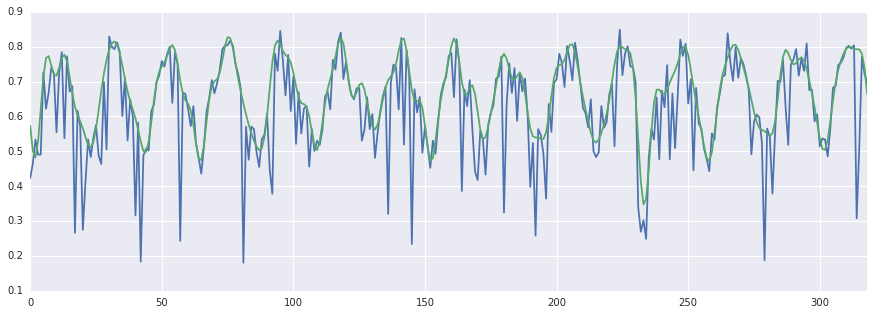

(0, 319)

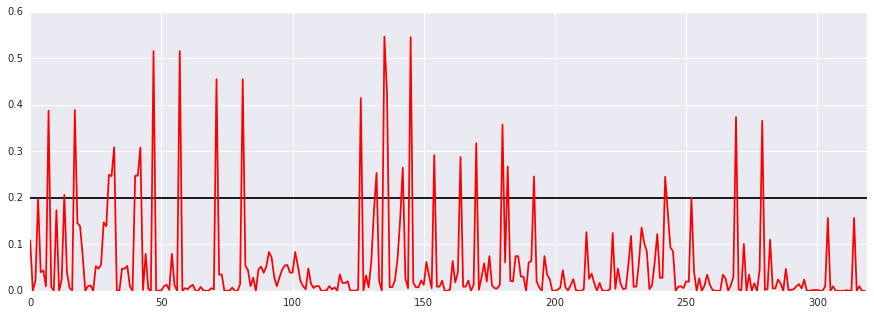

In [164]:
plt.figure(figsize=(15,5))
raw.NDVI.plot()
raw['NDVI reconstructed'].plot()
plt.show()
plt.figure(figsize=(15,5))
plt.plot(y_pred_static[:,1],'r')
plt.hlines(0.2,0, 319)
plt.xlim(0,319)

In [165]:
mask = np.where(y_pred_static[:,1]>=0.2)

In [166]:
mask[0]

array([  7,  13,  17,  30,  31,  32,  40,  41,  42,  47,  57,  71,  81,
       126, 132, 135, 136, 142, 145, 154, 164, 170, 180, 182, 192, 242,
       269, 279], dtype=int64)

In [167]:
NDVI_raw = raw['NDVI'].as_matrix()#[mask[0]] = np.nan
NDVI_raw[mask[0]] = np.nan

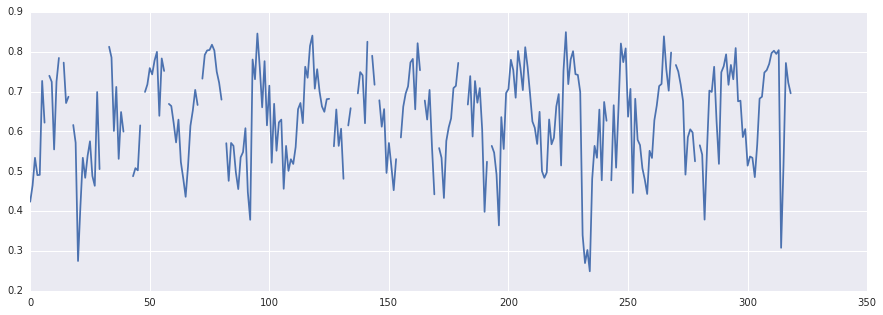

In [168]:
plt.figure(figsize=(15,5))
plt.plot(NDVI_raw)

In [169]:
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]
nans, x= nan_helper(NDVI_raw)
NDVI_raw[nans]= np.interp(x(nans), x(~nans), NDVI_raw[~nans])

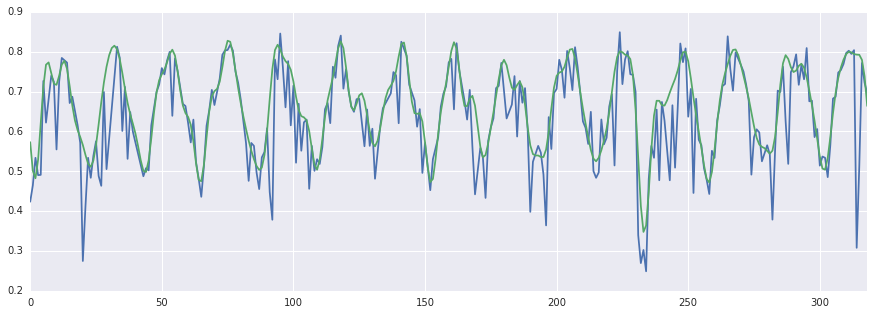

In [171]:
plt.figure(figsize=(15,5))
plt.plot(NDVI_raw)
raw['NDVI reconstructed'].plot()